In [72]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
import lightkurve as lk
from astropy.timeseries import LombScargle
import scipy.signal as signal

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
tessfits = glob.glob('tess_fits_files/*fits')
tessfits

['tess_fits_files/tess2019226182529-s0015-0000000259773610-0151-s_lc.fits',
 'tess_fits_files/tess2019253231442-s0016-0000000259773610-0152-s_lc.fits']

Do both lc's separatly, then combine

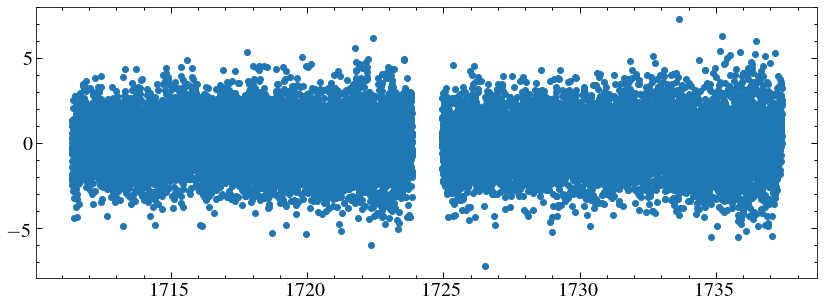

1.1432363435738948


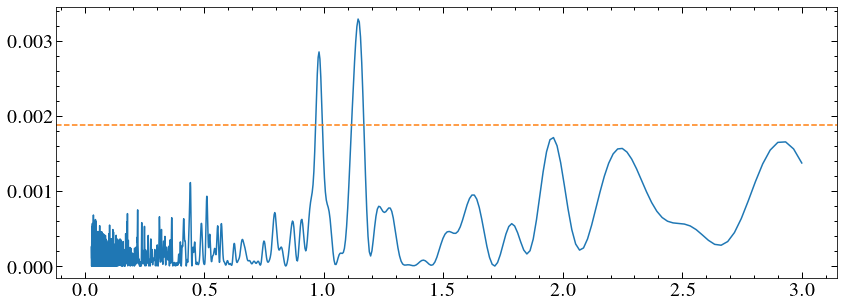

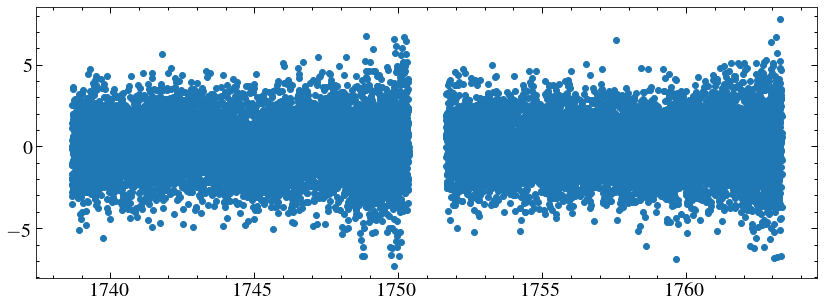

0.5706890939641176


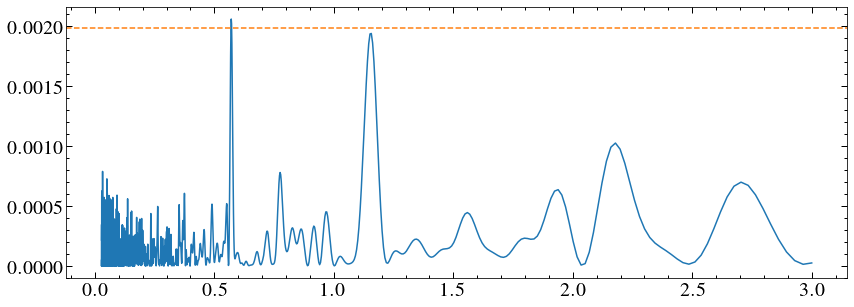

In [138]:
for ft in tessfits:
    data = fits.getdata(ft, 1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    #plt.scatter(t, f)
    #plt.show()
    t, f, e = t[q==0], f[q==0], e[q==0]
    fit = 
    #f, e = f/np.mean(f), e/np.mean(e)
    #f = f / np.mean(f)
    f = (f/np.mean(f)*100)-100
    plt.scatter(t, f)
    plt.show()
    ls = LombScargle(t, f, normalization='model')
    frequency, power = ls.autopower(minimum_frequency=1/3, maximum_frequency=1/(240/8600), samples_per_peak=10)#, method='fastchi2') 
    #frequency, power = ls.autopower(minimum_frequency=1/3, maximum_frequency=1/0.6, samples_per_peak=10)#, method='fastchi2')
    plt.plot(1/frequency, power)
    plt.axhline(ls.false_alarm_level(0.01),ls='--', c='C1')
    print(1/frequency[np.argmax(power)])
    plt.show()

Fitting, trying KB's pyroid package (No, doesn't seem to work for long periods.

In [119]:
#https://lmfit.github.io/lmfit-py/parameters.html

from lmfit import Minimizer, Parameters, report_fit


# define objective function: returns the array to be minimized
def fcn2min(params, x, data):
    """Model a decaying sine wave and subtract data."""
    amp = params['amp']
    shift = params['shift']
    omega = params['omega']
    model = amp * np.sin(x*omega + shift)
    return model - data

def sinfit(t, f):
# create a set of Parameters
    params = Parameters()
    params.add('amp', value=1.0, min=0.)
    params.add('shift', value=0.0, min=-np.pi/2., max=np.pi/2.)
    params.add('omega', value=1/1.15)

    # do fit, here with the default leastsq algorithm
    minner = Minimizer(fcn2min, params, fcn_args=(t, f))
    result = minner.minimize()

    # calculate final result
    final = f + result.residual

    # write error report
    report_fit(result)

    # try to plot results
    try:
        import matplotlib.pyplot as plt
        plt.plot(t, f, 'k+')
        plt.plot(t, final, 'r')
        plt.show()
    except ImportError:
        pass

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 71
    # data points      = 1784
    # variables        = 3
    chi-square         = 506.740610
    reduced chi-square = 0.28452589
    Akaike info crit   = -2239.36748
    Bayesian info crit = -2222.90764
[[Variables]]
    amp:    0.03925993 +/- 0.01838881 (46.84%) (init = 1)
    shift:  1.57074911 +/- 40.0192960 (2547.78%) (init = 0)
    omega:  0.86734818 +/- 0.05728162 (6.60%) (init = 0.8695652)
[[Correlations]] (unreported correlations are < 0.100)
    C(shift, omega) = -1.000


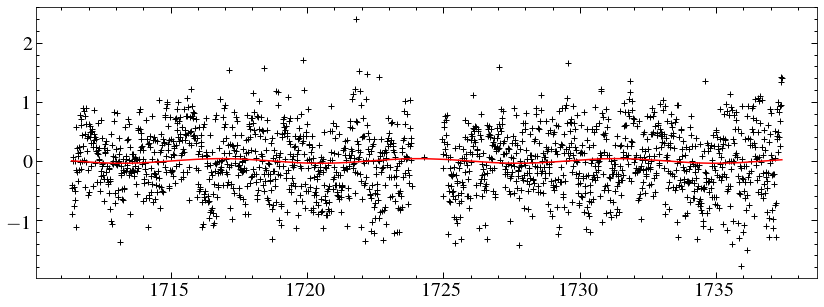

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 67
    # data points      = 1681
    # variables        = 3
    chi-square         = 503.117280
    reduced chi-square = 0.29983151
    Akaike info crit   = -2021.82531
    Bayesian info crit = -2005.54388
[[Variables]]
    amp:    0.05433729 +/- 0.01879077 (34.58%) (init = 1)
    shift: -1.57060978 +/- 399.910316 (25462.11%) (init = 0)
    omega:  0.86765974 +/- 0.04638184 (5.35%) (init = 0.8695652)
[[Correlations]] (unreported correlations are < 0.100)
    C(shift, omega) =  1.000


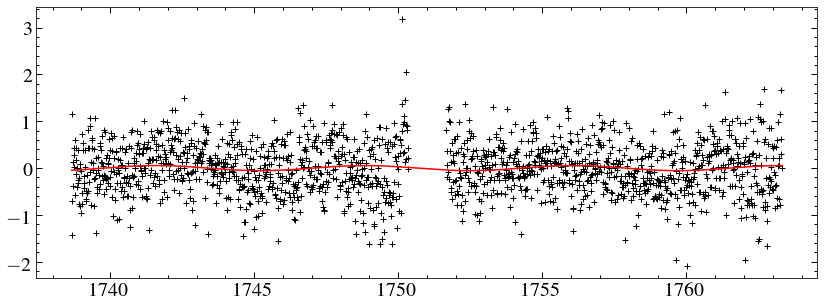

In [122]:
for ft in tessfits:
    data = fits.getdata(ft, 1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    #plt.scatter(t, f)
    #plt.show()
    t, f, e = t[q==0], f[q==0], e[q==0]
    #f, e = f/np.mean(f), e/np.mean(e)
    #f = f / np.mean(f)
    e = e/f
    f = (f/np.mean(f)*100)-100
    e = e*f
    lc = lk.LightCurve(time=t, flux=f, flux_err=e )
    lc = lc.bin(10)
    sinfit(lc.time,lc.flux)
    #plt.scatter(t, f)

How does astropy do?

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude           frequency            phase       
    -------------------- ------------------ ------------------
    -0.12378846558310981 0.8737862818458311 -7.502400544779635


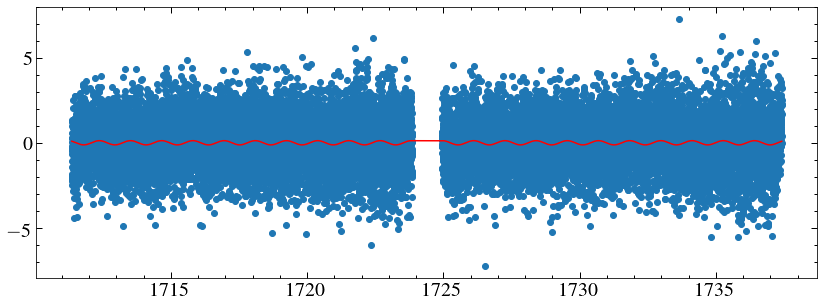

Model: Sine1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
         amplitude           frequency            phase      
    -------------------- ------------------ -----------------
    -0.10426601574943796 0.8662667624672721 5.635392498861237


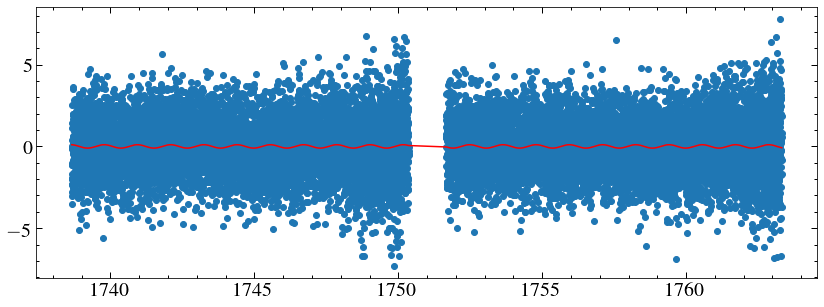

In [143]:
fitter = fitting.LevMarLSQFitter()

def apfit(t, f):

    sin_mod =  models.Sine1D(amplitude=1, frequency=1/1.15, bounds={'frequency':[1/1.16, 1/1.12]})
    sin_fit = fitter(sin_mod, t, f, maxiter=100000)
    return sin_fit

for ft in tessfits:
    data = fits.getdata(ft, 1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    #plt.scatter(t, f)
    #plt.show()
    t, f, e = t[q==0], f[q==0], e[q==0]
    #f, e = f/np.mean(f), e/np.mean(e)
    #f = f / np.mean(f)
    e = e/f
    f = (f/np.mean(f)*100)-100
    e = e*f
    lc = lk.LightCurve(time=t, flux=f, flux_err=e )
    #lc = lc.bin(30)
    sin_fit = apfit(lc.time,lc.flux)
    print(sin_fit)
    plt.scatter(lc.time, lc.flux)
    plt.plot(lc.time, sin_fit(lc.time), c='r')
    plt.show()

Nope.

ValueError: normalization='amplitude' not recognized

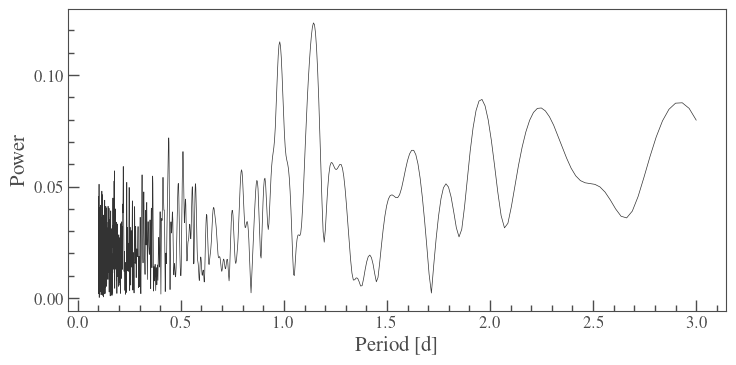

In [171]:
for ft in tessfits:
    data = fits.getdata(ft, 1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    #plt.scatter(t, f)
    #plt.show()
    t, f, e = t[q==0], f[q==0], e[q==0]
    #f, e = f/np.mean(f), e/np.mean(e)
    #f = f / np.mean(f)
    e = e/f
    f = (f/np.mean(f)*100)-100
    e = e*f
    lc = lk.LightCurve(time=t, flux=f, flux_err=e )
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=0.1*u.day, maximum_period=3*u.day)
    pg.plot()
    ls = LombScargle(t, f)
    power = ls.power(pg.frequency.value)
    plt.plot(1/pg.frequency, power*40)
    #plt.plot(pg.frequency, power/pg.power)

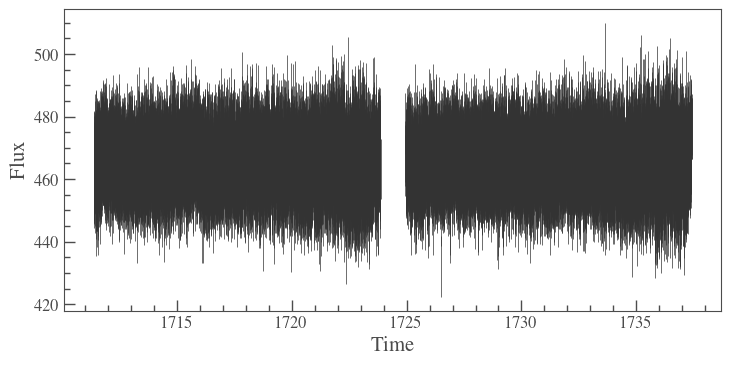

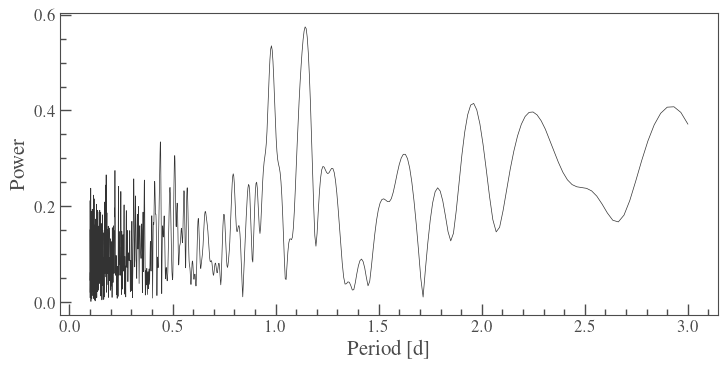

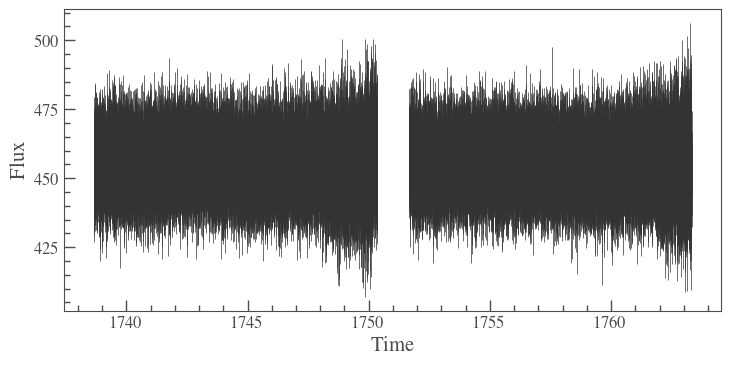

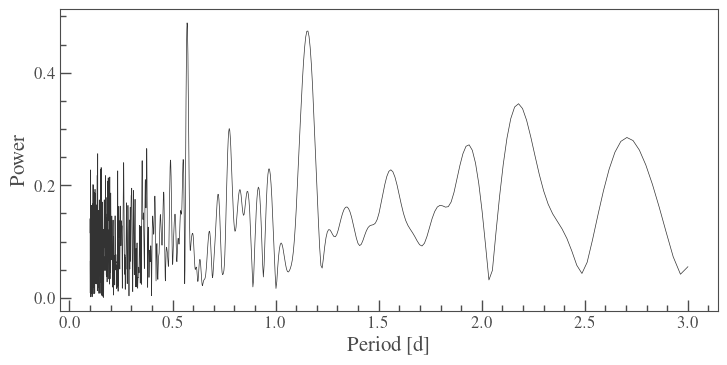

In [186]:
for ft in tessfits:
    data = fits.getdata(ft, 1)
    t, f, e, q = data['TIME'], data['PDCSAP_FLUX'], data['PDCSAP_FLUX_ERR'], data['QUALITY']
    #plt.scatter(t, f)
    #plt.show()
    t, f, e = t[q==0], f[q==0], e[q==0]
    #f, e = f/np.mean(f), e/np.mean(e)
    #f = f / np.mean(f)
   # e = e/f
   # f = (f/np.mean(f)*100)-100
    #e = e*f
    lc = lk.LightCurve(time=t, flux=f, flux_err=e ).remove_outliers(sigma=5)
    #lcf, trend = lc.flatten(1000001, return_trend=True)
    lc.errorbar()
    pg = lc.to_periodogram(oversample_factor=10,minimum_period=0.1*u.day, maximum_period=3*u.day)
    pg.plot()